In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [25]:
from sqlalchemy import create_engine
import psycopg2

engine = create_engine(f'postgresql+psycopg2://{user}:{password}\
@localhost:5432/movies_db')
conn = engine.connect()

In [26]:
csv1 = "movie_data/movies.csv"
csv2 = "movie_data/ratings.csv"
csv3 = "movie_data/genome-scores.csv"
csv4 = "movie_data/genome-tags.csv"
csv5 = "movie_data/links.csv"
csv6 = "movie_data/tags.csv"

In [27]:
# import using postgres / sqlalchemy
movies_df = pd.read_sql("SELECT * FROM movies", conn)
movies_df.head()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
movies_df = pd.read_csv(csv1)
ratings_df = pd.read_csv(csv2)
genome_scores_df = pd.read_csv(csv3)
genome_tags_df = pd.read_csv(csv4)
links_df = pd.read_csv(csv5)
tags_df = pd.read_csv(csv6)

In [29]:
print(f'{len(movies_df)} movies')
print(f'{len(ratings_df)} ratings')

62423 movies
25000095 ratings


In [30]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [31]:
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [32]:
# filtering for the most relevant genome scores
relevant_genome_scores_df = genome_scores_df.loc[genome_scores_df['relevance'] > .85]

In [33]:
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [34]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [35]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [36]:
# merging movies and ratings dataframes

new_df = ratings_df.merge(movies_df, how="inner")
new_df = new_df.drop(columns=['title', 'genres', 'timestamp'])
new_df.head()

,userId,movieId,rating
0,1,296,5.0
1,3,296,5.0
2,4,296,4.0
3,5,296,4.0
4,7,296,4.0


In [37]:
# applying 1's and 0's to rating column where the rating is greater or equal to 3.5 / 5 
# whether the reviewer liked the movie or not

new_df["rating"] = np.where(new_df["rating"] >= 3.5, 1, 0)

In [38]:
# data split into features and results for logistic regression

X = new_df.drop('rating', axis=1)
y = new_df['rating']

In [39]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)

#view transformed values
print(y_transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, random_state=1)

[1 1 1 ... 1 1 1]


In [40]:
# fitting classifier to our model

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6251565127406717
Testing Data Score: 0.625341598688261


## Plots

In [41]:
# merging movie and ratings

movie_ratings = movies_df.merge(ratings_df, how="inner")
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517
...,...,...,...,...,...,...
25000090,209157,We (2018),Drama,119571,1.5,1574280748
25000091,209159,Window of the Soul (2001),Documentary,115835,3.0,1574280985
25000092,209163,Bad Poems (2018),Comedy|Drama,6964,4.5,1574284913
25000093,209169,A Girl Thing (2001),(no genres listed),119571,3.0,1574291826


In [42]:
# grabbing reduced sample, extracting year_released string from title

reduced = movie_ratings.sample(1000000)
reduced['year'] = reduced.title.str.extract('\((.*)\)')[0]

reduced['release_year'] = reduced['year'].str.split('(').str[-1]
reduced = reduced.drop(columns = ['year'])
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year
5702597,1079,"Fish Called Wanda, A (1988)",Comedy|Crime,51691,1.0,1079967709,1988
1222008,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,155958,4.0,848842391,1995
4925574,858,"Godfather, The (1972)",Crime|Drama,31636,5.0,856689990,1972
21271601,59615,Indiana Jones and the Kingdom of the Crystal S...,Action|Adventure|Comedy|Sci-Fi,149554,2.5,1436526135,2008
12276833,2858,American Beauty (1999),Drama|Romance,72247,4.5,1232988349,1999


In [43]:
# available genre categories

genres = ['Comedy','Adventure','Animation','Children','Fantasy','Romance','Drama',
          'Documentary','Action','Horror','Mystery','Sci-Fi','Western','Crime','Thriller',
          'Film-Noir','Musical','War']
print(len(genres))

18


In [44]:
# Function to sort dataframe by inputted genre

def genre_ratings(genre):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    return df

In [45]:
genre_ratings('Film-Noir').head()

,movieId,title,genres,userId,rating,timestamp,release_year
8572195,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,148319,3.0,1042163671,1997
11958999,2727,Killer's Kiss (1955),Crime|Film-Noir,150633,4.0,940325555,1955
6576277,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller,5416,4.0,1545078587,1949
5284372,930,Notorious (1946),Film-Noir|Romance|Thriller,87138,4.5,1165235188,1946
8566047,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,112342,5.0,945191310,1997


In [46]:
# Average rating for each genre

genre_averages = {
    'Genre': [],
    'Average Rating': []
}
for genre in genres:
    avg_rating = genre_ratings(genre)['rating'].mean()
    genre_averages['Genre'].append(genre)
    genre_averages['Average Rating'].append(avg_rating)

genre_avg_df = pd.DataFrame(genre_averages).sort_values('Average Rating', ascending=False)

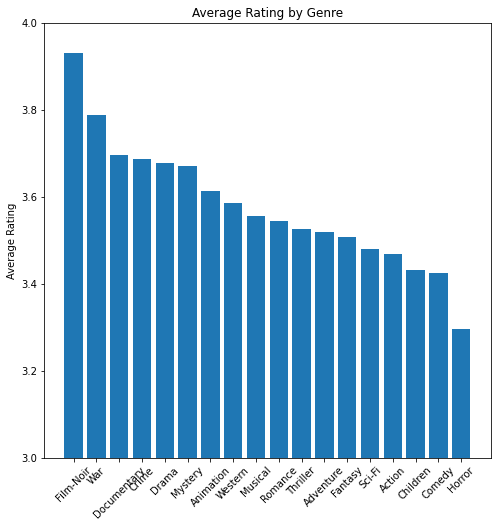

In [47]:
# Plotting average rating for each genre

plt.figure(figsize=(8, 8))
plt.bar(genre_avg_df['Genre'],genre_avg_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.savefig('images/avg_rating_by_genre.png')

In [48]:
# Function to grab average ratings for a given year and given genre

def ratings_by_year(genre, year):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[df['release_year'] == year]
    avg_rating = year_df.groupby('release_year')['rating'].mean()
    return avg_rating[0]

In [49]:
ratings_by_year('Action','1995')

3.2662888742882172

In [50]:
# Years 1993 - 2018, grabbing average rating for action movies (precursor to below function)

ratings_dict = {
    'Year': [],
    'Average Rating': []
}

years = ['1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006',
         '2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

for year in years:
    avg = ratings_by_year('Action',year)
    ratings_dict['Average Rating'].append(avg)
    ratings_dict['Year'].append(year)
    
ratings_dict_df = pd.DataFrame(ratings_dict)

In [51]:
ratings_dict_df.head()

,Year,Average Rating
0,1993,3.335983
1,1994,3.338933
2,1995,3.266289
3,1996,3.259269
4,1997,3.247236


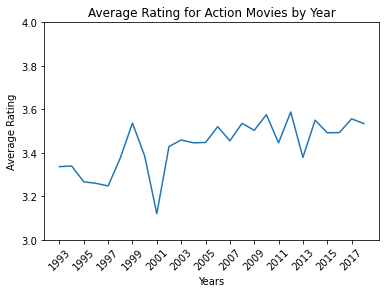

In [52]:
plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating for Action Movies by Year')
plt.ylabel('Average Rating')
plt.xlabel('Years')

#every other year for xticks
labels = [n for n in ratings_dict_df['Year']][::2]
plt.xticks(labels,labels=labels,rotation=45)
plt.savefig('images/average_rating_action.png')

In [53]:
# function to produce plots for each inputted genre over the years

def plot_genre_by_year(genre):
    lower_genre = genre.lower()
    ratings_dict = {
        'Year': [],
        'Average Rating': []
    }

    # years list in string format
    years = ['19'+str(i) for i in range(60, 100)]+['200'+str(i) for i in range(0,10)]+['20'+str(i) for i in range(10,19)]

    year_labels = years[::4]

    for year in years:
        try:
            avg = ratings_by_year(genre,year)
            ratings_dict['Average Rating'].append(avg)
            ratings_dict['Year'].append(year)
        except:
            pass

    ratings_dict_df = pd.DataFrame(ratings_dict)

    ## Plot
    plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'], label=genre)
    plt.ylim(3, 5)
    plt.title(f'Average Rating for {genre} Movies by Year')
    plt.ylabel('Average Rating')
    plt.xlabel('Years')
    plt.xticks(year_labels,labels=year_labels,rotation=45)
    plt.savefig(f'images/avg_rating_by_year_{lower_genre}.png')
    plt.show()

In [54]:
def plot_genre_by_year_single_plot(genre):
    lower_genre = genre.lower()
    ratings_dict = {
        'Year': [],
        'Average Rating': []
    }

    years = ['19'+str(i) for i in range(60, 100)]+['200'+str(i) for i in range(0,10)]+['20'+str(i) for i in range(10,19)]

    year_labels = years[::4]

    for year in years:
        try:
            avg = ratings_by_year(genre,year)
            ratings_dict['Average Rating'].append(avg)
            ratings_dict['Year'].append(year)
        except:
            pass

    ratings_dict_df = pd.DataFrame(ratings_dict)

    ## Plot
    plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'], label=genre)
    plt.ylim(3, 5)
    plt.title(f'Average Rating for all Genres by Year')
    plt.ylabel('Average Rating')
    plt.xlabel('Years')
    plt.xticks(year_labels,labels=year_labels,rotation=45)
    plt.legend(loc="upper right")
    plt.savefig(f'images/all_genre.png')
plt.show()

In [55]:
# list of top genres to make plots for

top_genres = ['War','Documentary','Crime','Drama','Mystery','Animation','Action']

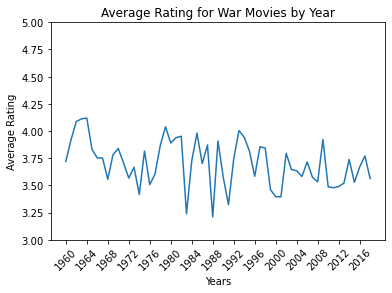

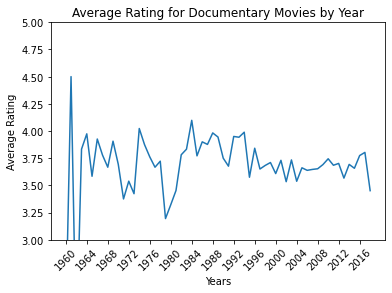

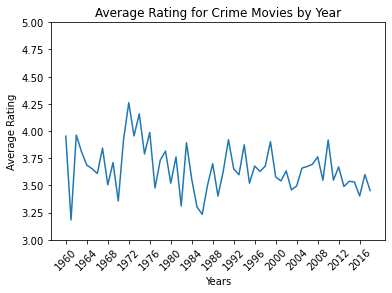

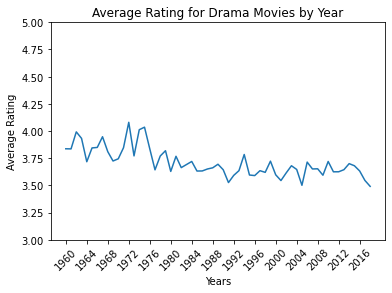

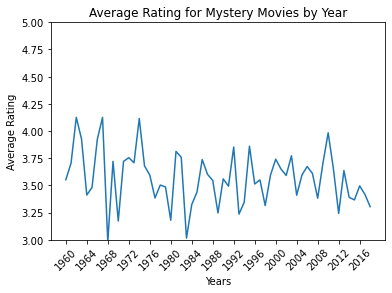

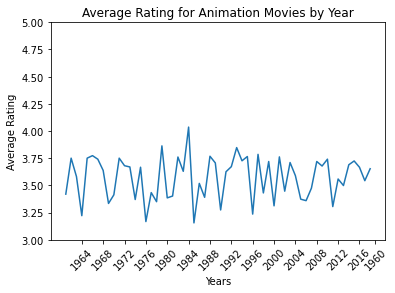

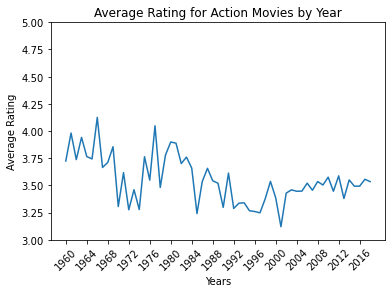

In [56]:
for genre in top_genres:
    plot_genre_by_year(genre)

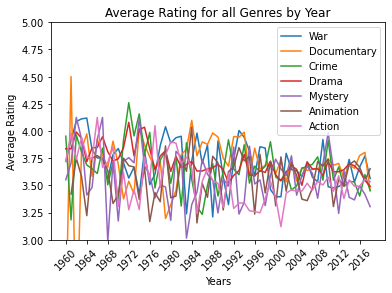

In [57]:
for genre in top_genres:
    plot_genre_by_year_single_plot(genre)

In [58]:
ratings_df.timestamp

0           1147880044
1           1147868817
2           1147868828
3           1147878820
4           1147868510
               ...    
25000090    1240953372
25000091    1240951998
25000092    1240950697
25000093    1240953434
25000094    1240952515
Name: timestamp, Length: 25000095, dtype: int64

In [59]:
# convert timestamp values to datetime to extract review_year

ratings_df['reviewDate'] = pd.to_datetime(ratings_df.timestamp, unit='s')

In [60]:
ratings_df['reviewYear'] = ratings_df.reviewDate.dt.year

In [61]:
# Getting date range, reviews start in 1995-2019
ratings_df.sort_values('reviewDate').head()

,userId,movieId,rating,timestamp,reviewDate,reviewYear
326761,2262,21,3.0,789652009,1995-01-09 11:46:49,1995
326810,2262,1079,3.0,789652009,1995-01-09 11:46:49,1995
326767,2262,47,5.0,789652009,1995-01-09 11:46:49,1995
15845015,102689,1,4.0,822873600,1996-01-29 00:00:00,1996
15845023,102689,39,5.0,822873600,1996-01-29 00:00:00,1996


In [62]:
# search cult classic movies to find movieId and build cc list below

movies_df.loc[movies_df.title.str.contains('Pulp Fiction')]

,movieId,title,genres
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


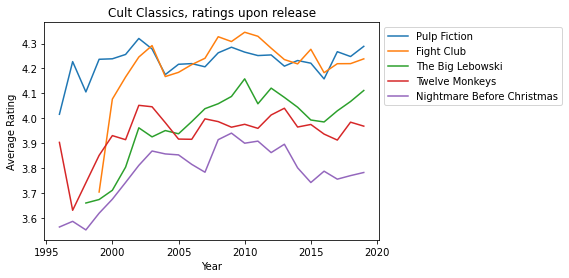

<Figure size 720x576 with 0 Axes>

In [63]:
# Searching for cult classics to track ratings since release
# Plot ratings over the years since the movies release
# movieName, movieId

cult_classics = [['Pulp Fiction', 296], ['Fight Club', 2959], ['The Big Lebowski', 1732], 
                 ['Twelve Monkeys', 32], ['Nightmare Before Christmas', 551]]

for i, k in cult_classics:
    plt.plot(ratings_df.loc[ratings_df.movieId == k].groupby('reviewYear')['rating'].mean(), label=i)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.title('Cult Classics, ratings upon release')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.savefig(f'images/cult-classics.png')
plt.show()

In [64]:
reduced = movie_ratings.sample(1000000)
reduced['year'] = reduced.title.str.extract('\((.*)\)')[0]

reduced['release_year'] = reduced['year'].str.split('(').str[-1]
reduced = reduced.drop(columns = ['year'])
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year
19041460,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,152980,2.5,1221496346,2004
10057174,2096,Sleeping Beauty (1959),Animation|Children|Musical,19236,4.0,1430210466,1959
16125666,4995,"Beautiful Mind, A (2001)",Drama|Romance,20590,4.0,1289308332,2001
5606813,1047,"Long Kiss Goodnight, The (1996)",Action|Drama|Thriller,29179,3.0,1086523991,1996
22175753,76175,Clash of the Titans (2010),Action|Adventure|Drama|Fantasy,91401,2.5,1460785251,2010


In [65]:
reduced.release_year.unique()

array(['2004', '1959', '2001', '1996', '2010', '2011', '1992', '1999',
       '1991', '1994', '1997', '1998', '2012', '1984', '2006', '2008',
       '1989', '2017', '2019', '1983', '1942', '1974', '1995', '1985',
       '1971', '2009', '2003', '2014', '1988', '2013', '2000', '2002',
       '2015', '1990', '1980', '2005', '2007', '1976', '1950', '1954',
       '1982', '1981', '1939', '1970', '1946', '1953', '1987', '1993',
       '1958', '1979', '1961', '1951', '1966', '1967', '1962', '1986',
       '1934', '1937', '2018', '1963', '1969', '2016', '1945', '1975',
       '1977', '1978', '1960', '1964', '1932', '1938', '1940', '1924',
       '1957', '1965', '1972', '1968', '1955', '1973', '1956', '1935',
       '1936', '1949', '2006–2007', '1927', '1947', '1933', '1922', nan,
       '1941', '1925', '1952', '1944', '1948', '1931', '1919', '1916',
       '1943', '1903', '1928', '1929', '1930', '1902', '1926', '1914',
       '1920', '1923', '1921', '1894', '1917', '1888', '1892', '1897',
    

In [68]:
# cleaning release_year stringed data to convert to int
reduced = reduced[reduced['release_year'].str.contains('2006–2007')==False]
reduced = reduced[reduced['release_year'].str.contains('Close Relations')==False]
reduced = reduced[reduced['release_year'].str.contains('1983\)')==False]
reduced = reduced[reduced['release_year'].str.contains('Your Past Is Showing')==False]
reduced = reduced[reduced['release_year'].str.contains('Das Millionenspiel')==False]

reduced['reviewDate'] = pd.to_datetime(reduced.timestamp, unit='s')
reduced['reviewYear'] = reduced.reviewDate.dt.year

In [69]:
reduced.release_year = pd.to_numeric(reduced.release_year)

In [70]:
print(f'{len(reduced)} entries')

999516 entries


In [71]:
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year,reviewDate,reviewYear
19041460,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,152980,2.5,1221496346,2004,2008-09-15 16:32:26,2008
10057174,2096,Sleeping Beauty (1959),Animation|Children|Musical,19236,4.0,1430210466,1959,2015-04-28 08:41:06,2015
16125666,4995,"Beautiful Mind, A (2001)",Drama|Romance,20590,4.0,1289308332,2001,2010-11-09 13:12:12,2010
5606813,1047,"Long Kiss Goodnight, The (1996)",Action|Drama|Thriller,29179,3.0,1086523991,1996,2004-06-06 12:13:11,2004
22175753,76175,Clash of the Titans (2010),Action|Adventure|Drama|Fantasy,91401,2.5,1460785251,2010,2016-04-16 05:40:51,2016


In [72]:
# find average ratings for genres over the years, selecting for both reviewYear and release_year

def ratings_by_review_year(genre, year):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[(df.reviewYear >= year) & (df.release_year >= year)]
    avg_rating = year_df.groupby('reviewYear')['rating'].mean()
    return avg_rating

In [73]:
# using above function to plot each genre

def plot_review_by_year(genres, year):
    titles = []
    for genre in genres:
        df = reduced[reduced['genres'].str.contains(genre, regex=False)]
        year_df = df.loc[df.reviewYear >= year]
        avg_rating = year_df.groupby('reviewYear')['rating'].mean()
        
        plt.plot(avg_rating, label=genre)
        plt.ylim(3.0,4.5)
        plt.xlabel("Year of Review")
        plt.ylabel("Average Rating")
        plt.xticks(range(year,2019)[::4])
        plt.legend(loc="upper right")
        titles.append(genre)
    plt.title(f'Movies by Review Year')
    plt.savefig(f'images/by_review_year/{titles[0]}-{titles[1]}')
    plt.show()

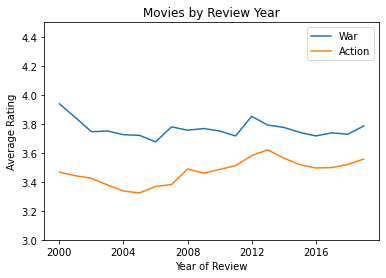

In [74]:
plot_review_by_year(['War','Action'], 2000)

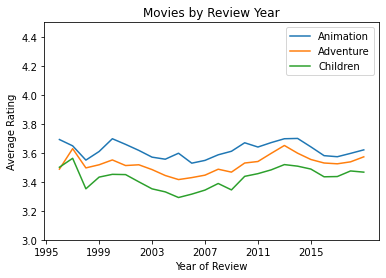

In [75]:
plot_review_by_year(['Animation','Adventure','Children'],1995)

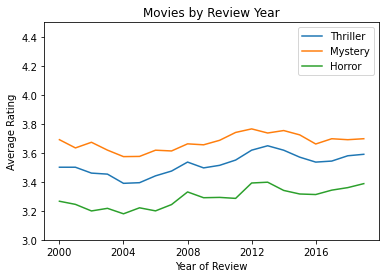

In [76]:
plot_review_by_year(['Thriller','Mystery','Horror'],2000)

In [77]:
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year,reviewDate,reviewYear
19041460,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,152980,2.5,1221496346,2004,2008-09-15 16:32:26,2008
10057174,2096,Sleeping Beauty (1959),Animation|Children|Musical,19236,4.0,1430210466,1959,2015-04-28 08:41:06,2015
16125666,4995,"Beautiful Mind, A (2001)",Drama|Romance,20590,4.0,1289308332,2001,2010-11-09 13:12:12,2010
5606813,1047,"Long Kiss Goodnight, The (1996)",Action|Drama|Thriller,29179,3.0,1086523991,1996,2004-06-06 12:13:11,2004
22175753,76175,Clash of the Titans (2010),Action|Adventure|Drama|Fantasy,91401,2.5,1460785251,2010,2016-04-16 05:40:51,2016


In [78]:
avg = reduced.groupby('movieId').mean()

In [79]:
avg.sort_values('rating', ascending=False)

,userId,rating,timestamp,release_year,reviewYear
movieId,,,,,
158958,20385.0,5.0,1.562854e+09,2003.0,2019.0
149606,40014.0,5.0,1.566526e+09,2015.0,2019.0
161962,58599.0,5.0,1.489176e+09,2015.0,2017.0
42548,85757.0,5.0,1.482247e+09,1949.0,2016.0
162436,134540.0,5.0,1.477307e+09,1971.0,2016.0
...,...,...,...,...,...
69489,36324.0,0.5,1.437450e+09,1970.0,2015.0
174603,75839.0,0.5,1.500255e+09,2013.0,2017.0
174597,91633.0,0.5,1.553118e+09,2012.0,2019.0


In [80]:
year_df = reduced.loc[reduced.release_year >= 1995]

In [81]:
top_year_df = year_df.loc[year_df.rating > 4]

In [82]:
top_year_df

,movieId,title,genres,userId,rating,timestamp,release_year,reviewDate,reviewYear
12564672,2959,Fight Club (1999),Action|Crime|Drama|Thriller,56092,4.5,1558216918,1999,2019-05-18 22:01:58,2019
16069298,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,15643,4.5,1309019029,2001,2011-06-25 16:23:49,2011
18635015,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,115826,4.5,1105462064,2004,2005-01-11 16:47:44,2005
22590748,85020,"Mechanic, The (2011)",Action|Drama|Thriller,82788,5.0,1447455547,2011,2015-11-13 22:59:07,2015
23501828,104879,Prisoners (2013),Drama|Mystery|Thriller,135664,4.5,1447016450,2013,2015-11-08 21:00:50,2015
...,...,...,...,...,...,...,...,...,...
21053899,56782,There Will Be Blood (2007),Drama|Western,30000,5.0,1213603742,2007,2008-06-16 08:09:02,2008
8245765,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi,31502,4.5,1218752611,1997,2008-08-14 22:23:31,2008
996192,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller,240,5.0,962964123,1995,2000-07-07 10:02:03,2000
20369942,48516,"Departed, The (2006)",Crime|Drama|Thriller,139123,5.0,1475977551,2006,2016-10-09 01:45:51,2016


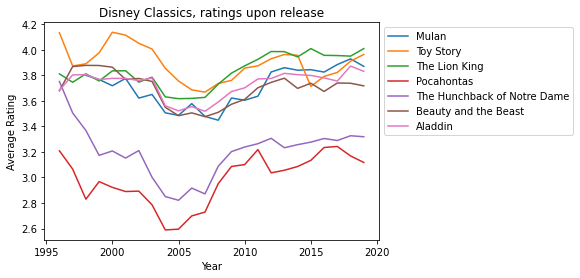

<Figure size 720x576 with 0 Axes>

In [83]:
disney_classics = [['Mulan', 1907], ['Toy Story', 1], ['The Lion King', 364], 
                 ['Pocahontas', 48], ['The Hunchback of Notre Dame', 783],
                   ['Beauty and the Beast', 595], ['Aladdin',588]]

for i, k in disney_classics:
    plt.plot(ratings_df.loc[ratings_df.movieId == k].groupby('reviewYear')['rating'].mean(), label=i)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.title('Disney Classics, ratings upon release')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.savefig(f'images/disney-classics.png')
plt.show()